In [2]:
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt

In [9]:
import torch
import torch_directml

# Initialize the DirectML device
dml = torch_directml.device()
print(f"Using device: {dml}")

# Check device type
print(f"Device type: {dml.type}")
print(f"Device index: {dml.index}")

# Create a tensor and move it to the DirectML device
x = torch.tensor([1.0, 2.0, 3.0], device=dml)
print(f"Tensor on GPU: {x}")

# Perform a simple operation on the tensor
y = x * 2
print(f"Result after computation on GPU: {y}")


Using device: privateuseone:0
Device type: privateuseone
Device index: 0
Tensor on GPU: tensor([1., 2., 3.], device='privateuseone:0')
Result after computation on GPU: tensor([2., 4., 6.], device='privateuseone:0')


In [17]:
import torch

# Check if DirectML is available
print("DirectML available:", torch_directml.is_available())

# Create a tensor on the DirectML device
if torch_directml.is_available():
    device = torch_directml.device()
    x = torch.tensor([1.0, 2.0, 3.0], device=device)
    print("Tensor on GPU (DirectML):", x)
else:
    print("DirectML not available.")

DirectML available: True
Tensor on GPU (DirectML): tensor([1., 2., 3.], device='privateuseone:0')


In [5]:
torch.directml

AttributeError: module 'torch' has no attribute 'directml'

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images_per_label=800):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.max_images_per_label = max_images_per_label

        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                images = [os.path.join(subdir_path, file) for file in os.listdir(subdir_path)
                          if file.endswith(('.png', '.jpeg', '.jpg'))]
                # Randomly select up to max_images_per_label images
                selected_images = random.sample(images, min(len(images), self.max_images_per_label))
                self.image_files.extend(selected_images)
                self.labels.extend([subdir] * len(selected_images))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def to_dataframe(self):
        return pd.DataFrame({
            'image_path': self.image_files,
            'label': self.labels
        })

#### commented cells

#### Done Comments

In [5]:
def show_images(images, labels, n_images=10):
    # Denormalize images if needed (assuming ToTensor() was used without normalization)
    # Convert from tensor (C, H, W) to numpy (H, W, C) and transpose dimensions
    images = images.permute(0, 2, 3, 1).numpy()

    # Create a figure to display the images
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images):
        image = images[i]
        label = labels[i]

        # Show the image
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(label)

    plt.show()

In [6]:
base_dir='drive/MyDrive/my_shared_shortcut/Public'
folders = ['Honda', 'Suzuki', 'Yamaha', 'Others', 'VinFast']

## View the loaded image_path dataframe

In [8]:
import matplotlib.pyplot as plt
def view_df_value_counts(df, column_name='label',
                         title='View value counts',
                         xlabels='0: Others, 1: Honda, 2: Suzuki, 3: Yamaha, 4: VinFast',
                         ylabels='numbers of images'):
  item_counts = df[column_name].value_counts()
  item_counts.plot(kind='bar')
  plt.title(title)
  plt.xlabel(xlabels)
  plt.ylabel(ylabels)
  plt.show()

## Save the augmented dataset
## By passing through the augmented transformation pipeline

In [ ]:
# data_loader_tranformed = DataLoader(dataset_transformed, batch_size=32, shuffle=True)
# data_loader_tranformed

In [ ]:
# data_iter_transformed = iter(data_loader_tranformed)
# images, labels = next(data_iter_transformed)

### View some of the transformed by batch: CANNOT VIEW ALL SINCE IT'S THOUSANDS OF IMAGES!!

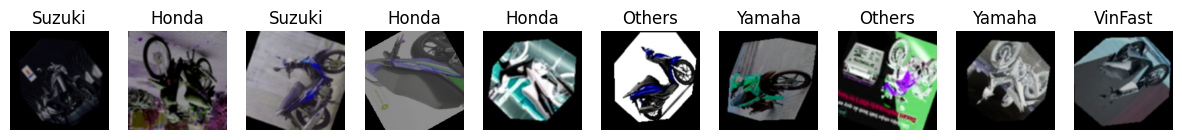

In [ ]:
# show_images(images, labels, n_images=10)

In [ ]:
import os
from torchvision import transforms

def save_transformed_dataset(dataset, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    # Iterate over each image and label in the dataset
    for i in range(len(dataset)):
        image, label = dataset[i]
        original_filename = os.path.basename(dataset.image_files[i])
        save_path = os.path.join(save_dir, label, original_filename)
        # Convert tensor to PIL image if needed
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        # Save the image
        print(save_path)
        image.save(save_path)
        # Print message for the first few images
        if i < 15:
            print(f"Saved image: {save_path}")

In [ ]:
save_transformed_dataset(dataset_transformed, save_dir='./transformed_images')

NameError: name 'dataset_transformed' is not defined

#### Delete in case fail

In [ ]:
!rm -r ./prepared-dataset

## Preparing for training

In [9]:
class DataFrameImage(Dataset):
    def __init__(self, dataframe, mapping={}, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mapping = mapping

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        # Load image
        image = Image.open(img_path).convert("RGB")
        # Apply transformation
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.mapping[label])  # Assuming label is a scalar or a tensor already
        return image, label

In [10]:
def save_transformed_dataset(dataset, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    # Iterate over each image and label in the dataset
    for i in range(len(dataset)):
        image, label = dataset[i]
        original_filename = os.path.basename(dataset.image_files[i])
        save_path = os.path.join(save_dir, label, original_filename)
        # Convert tensor to PIL image if needed
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        # Save the image
        print(save_path)
        image.save(save_path)
        # Print message for the first few images
        if i < 15:
            print(f"Saved image: {save_path}")

In [11]:
IMG_SIZE=224
augmented_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=90),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Start Training

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.nn import Dropout

In [25]:
def save_points(epoch, model, optimizer, scheduler, metrics_dict, best_acc, best_model_wts,checkpoint_filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics_dict': metrics_dict,
        'best_acc': best_acc,
        'best_model_wts': best_model_wts
         }, checkpoint_filename)
    
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25,checkpoint_dir='./models/'):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(1,num_epochs+1):
        metrics_dict = {}
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            metrics_dict[f"{phase}_loss"] = epoch_loss
            metrics_dict[f"{phase}_acc"] = epoch_acc

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        checkpoint_filename = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        print(f"saved model at {checkpoint_filename}")
        save_points(epoch, model, optimizer, scheduler, metrics_dict, best_acc, best_model_wts, checkpoint_filename)
        print('-' * 10)

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
label_mapping = {
    'Others': 0,
    'Honda': 1,
    'Suzuki': 2,
    'Yamaha': 3,
    'VinFast': 4
}
IMG_SIZE=224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
dataset_prepare = CustomImageDataset('./prepared-dataset', transform=None)
dataset_augment = CustomImageDataset('./augmented-dataset', transform=None)
df_path_pre = dataset_prepare.to_dataframe()
df_path_aug = dataset_augment.to_dataframe()

In [18]:
df_path_appended = pd.concat([df_path_pre, df_path_aug], ignore_index=True)

In [21]:
image_dataset = DataFrameImage(df_path_appended, mapping=label_mapping, transform=transform)
train_indices, val_indices = train_test_split(list(range(len(image_dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(image_dataset, train_indices)
val_dataset = Subset(image_dataset, val_indices)

In [22]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [23]:
print(len(train_dataset))

3976


In [24]:
num_classes = 5  # Number of classes in your dataset

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model.features.add_module('dropout', Dropout(p=0.5))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\nguye/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:04<00:00, 3.33MB/s]


In [26]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=80)

Epoch 1/79
train Loss: 1.3368 Acc: 0.4235
val Loss: 1.4025 Acc: 0.4195
saved model at ./models/model_epoch_1.pt
----------
Epoch 2/79


KeyboardInterrupt: 

In [12]:
torch.cuda.is_available()

False

In [13]:
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled